In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as ran
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#!wget https://vincentarelbundock.github.io/Rdatasets/csv/DAAG/dengue.csv

In [3]:
data = pd.read_csv('dengue.csv',delimiter=',')
#Z=data['Purchase'].copy()
llaves = ['humid', 'temp' , 'h10pix', 'trees' , 'Xmin', 'Ymin']
data = data[llaves].dropna()
scale = StandardScaler()
data = scale.fit_transform(data)
clusters = KMeans(n_clusters=4)
maxClusters = 17
inertia0 = np.zeros(maxClusters-1)

for j in range(1,maxClusters):
    clusters = KMeans(n_clusters=j)
    clusters.fit(data)
    inertia0[j-1] = clusters.inertia_

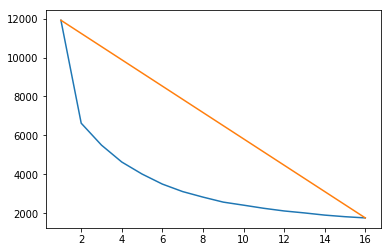

In [4]:
plt.plot(np.arange(1,maxClusters), inertia0)
plt.plot([1,maxClusters-1],[inertia0[0],inertia0[maxClusters-2]])

## El mejor número de clusters es 4, pues al usar el "método del codo", cuatro clusters maximizan la distancia a la recta anaranjada.

# Parte 2


In [24]:
semana = {0:"Lunes",1:"Martes",2:"Miércoles",3:"Jueves",4:"Viernes",5:"Sábado", 6:"Domingo"}
def readDate(date):
    year, month, day = np.int64(str.split(date,"-"))
    return dt.date(year, month, day)

def readTime(time):
    hours, minutes, seconds = np.int64(str.split(time,":"))
    return dt.time(hours, minutes, seconds)

colores = {1:'r',2:'r',3:'r',4:'black',5:'black',6:'black',7:'black',8:'black',9:'black',10:'r',11:'r',12:'r',}

In [25]:
dataOriginal = pd.read_csv('BreadBasket_DMS.csv',delimiter=',')
datos = dataOriginal.copy()
#Se empieza estudiando los aglomeramientos de compras por días a la semana. 
#En particular se espera ver diferencias entre el fin de semana y la semana.
dates = datos['Date']
times = datos['Time']
nDates = []
horas = []
minu = []
segu = []
meses = []
dias = []
weekdays = np.zeros(len(dates))
datos['daySales'] = datos.groupby('Date',sort=False)['Date'].transform('count')
for i in range(len(dates)):
    weekdays[i] = readDate(dates[i]).weekday()
    nDates.append(dt.datetime.strptime(dates[i], '%Y-%m-%d').date().toordinal()) #es mucho más rápido así
    meses.append(dt.datetime.strptime(dates[i], '%Y-%m-%d').date().month) #es mucho más rápido así
    dias.append(dt.datetime.strptime(dates[i], '%Y-%m-%d').date().day) #es mucho más rápido así
    horas.append(dt.datetime.strptime(times[i], '%H:%M:%S').time().hour)
    minu.append(dt.datetime.strptime(times[i], '%H:%M:%S').time().minute)
    segu.append(dt.datetime.strptime(times[i], '%H:%M:%S').time().second)
#weekdays = readDate(dates.values)
#semana[readDate(dates[0]).weekday()]
#dates[0]
datos['diaSem'] = weekdays
datos['ordDate'] = nDates
datos['segu'] = segu
datos['minu'] = minu
datos['hour'] = horas
datos['month'] = meses
datos['day'] = dias
#dates.value_counts(sort=False)
#datos.groupby('Date',sort=False).count()


#llaves = ['daySales', 'ordDate', 'hour', 'minu', 'segu','Transaction','diaSem','month','days']
llaves = ['daySales', 'ordDate','diaSem','Transaction', 'hour','month']
llaves = ['daySales', 'ordDate','diaSem','Transaction', 'hour','month']
llaves = ['daySales', 'ordDate','diaSem','Transaction', 'hour','month']
#llaves = ['daySales', 'ordDate','diaSem','Transaction','month']


In [7]:
Y = datos[llaves]
scale = StandardScaler()
Y = scale.fit_transform(Y)
pca = PCA(n_components=len(llaves))
Y_pca = pca.fit(Y).transform(Y)
vectors = pca.components_.copy()

#print(vectors)
A = np.zeros(len(horas))
B = np.zeros(len(horas))
for i in range(len(A)):
    A[i] = np.dot(Y[i,:],vectors[0,:])
    B[i] = np.dot(Y[i,:],-vectors[1,:])

Text(0,0.5,'Second Principal Component')

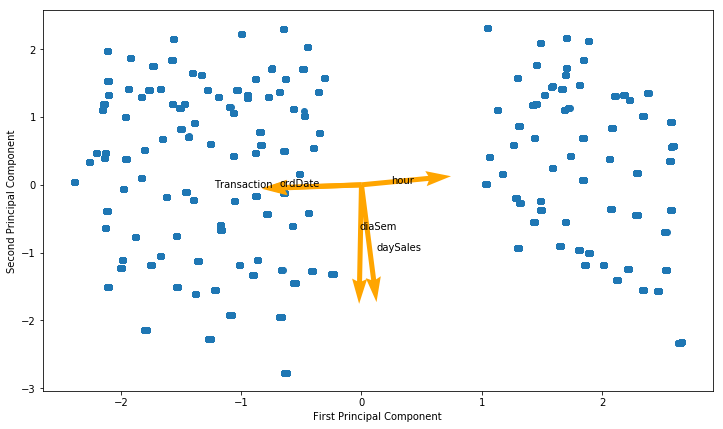

In [38]:
plt.figure(figsize=(12,(7)))
origin = [0], [0] # origin point
plt.scatter(A,B)

plt.quiver(*origin, vectors[0,:], -vectors[1,:], color='orange', scale=4)
for name,xy in zip(llaves,zip(vectors[0,:], -vectors[1,:])):
    #plt.annotate(name, xy=xy, textcoords='data')
    plt.annotate(name, xy=xy, xytext = 0.23*(len(name)-2)*np.array(xy), textcoords='data')
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")


(0, 1.03)

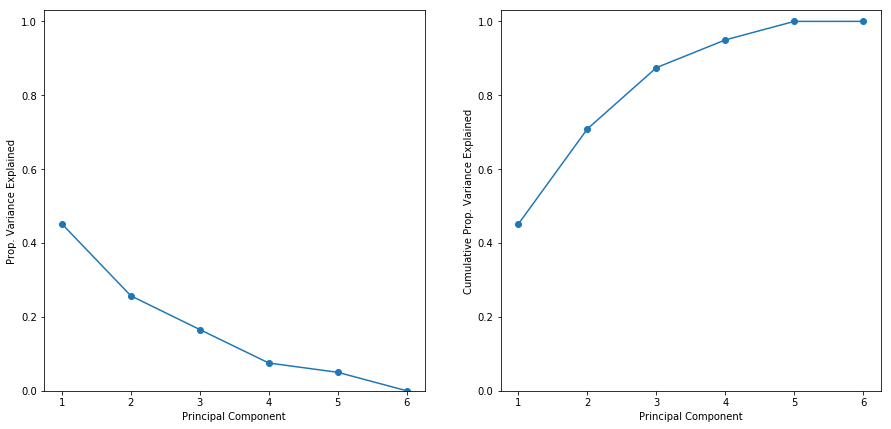

In [9]:
fig = plt.figure(figsize=(15,(7)))
ax = fig.add_subplot(121)
plt.scatter(np.arange(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylim(0,1.03)
plt.xlabel("Principal Component")
plt.ylabel("Prop. Variance Explained")
sumas = pca.explained_variance_ratio_.copy()
for i in range(1,len(sumas)):
    sumas[i] = pca.explained_variance_ratio_[0:i+1].sum()
ax = fig.add_subplot(122)
plt.scatter(np.arange(1,len(sumas)+1),sumas)
plt.plot(np.arange(1,len(sumas)+1),sumas)
plt.ylabel("Cumulative Prop. Variance Explained")
plt.xlabel("Principal Component")
plt.ylim(0,1.03)

Se probró diferentes combinaciones de variables y se encontró en particular que la hora tiene un vector bastante pequeño, indicando que la hora en la que se realiza la compra no influye en la varianza notoriamente(un hallazgo interesante pues siendo una panadería en Edimburgo uno pensaría un que se consume más bebidas calientes en la mañana. Sería interesante chequear si la mayoría de productos ya son comidas calientes, por ejemplo)
Repitiendo el análisis sin horas:


Text(0,0.5,'Second Principal Component')

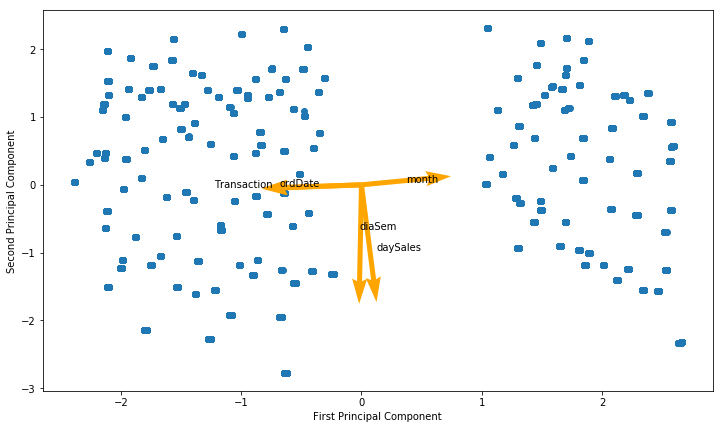

In [46]:
llaves = ['daySales', 'ordDate','diaSem','Transaction','month']
Y = datos[llaves].copy()
scale = StandardScaler()
Y = scale.fit_transform(Y)
pca = PCA(n_components=len(llaves))
Y_pca = pca.fit(Y).transform(Y)
vectors = pca.components_.copy()
#print(vectors)


A = np.zeros(len(horas))
B = np.zeros(len(horas))
for i in range(len(A)):
    A[i] = np.dot(Y[i,:],vectors[0,:])
    B[i] = np.dot(Y[i,:],-vectors[1,:])

plt.figure(figsize=(12,(7)))
origin = [0], [0] # origin point
plt.scatter(A,B)
plt.quiver(*origin, vectors[0,:], -vectors[1,:], color='orange', scale=4)
for name,xy in zip(llaves,zip(vectors[0,:], -vectors[1,:])):
    #plt.annotate(name, xy=xy, textcoords='data')
    plt.annotate(name, xy=xy, xytext = 0.23*(len(name)-2)*np.array(xy), textcoords='data')
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

(0, 1.03)

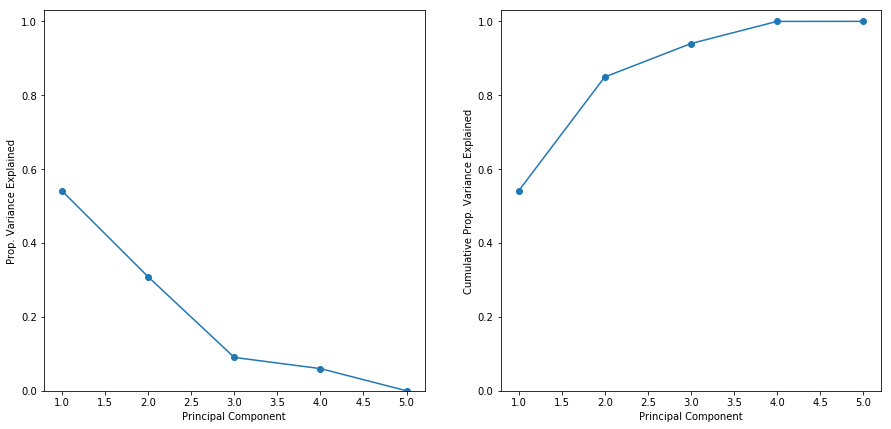

In [43]:
fig = plt.figure(figsize=(15,(7)))
ax = fig.add_subplot(121)
plt.scatter(np.arange(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.ylim(0,1.03)
plt.xlabel("Principal Component")
plt.ylabel("Prop. Variance Explained")
sumas = pca.explained_variance_ratio_.copy()
for i in range(1,len(sumas)):
    sumas[i] = pca.explained_variance_ratio_[0:i+1].sum()
ax = fig.add_subplot(122)
plt.scatter(np.arange(1,len(sumas)+1),sumas)
plt.plot(np.arange(1,len(sumas)+1),sumas)
plt.ylabel("Cumulative Prop. Variance Explained")
plt.xlabel("Principal Component")
plt.ylim(0,1.03)

In [54]:
clusters = KMeans(n_clusters=7)
maxClusters = 17
inertia1 = np.zeros(maxClusters-1)

for j in range(1,maxClusters):
    clusters = KMeans(n_clusters=j)
    clusters.fit(Y_pca)
    inertia1[j-1] = clusters.inertia_

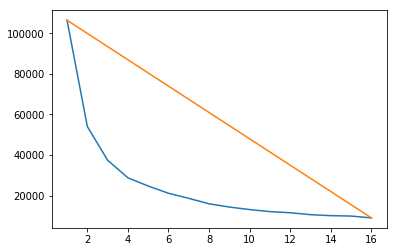

In [60]:
plt.plot(np.arange(1,maxClusters), inertia0)
plt.plot([1,maxClusters-1],[inertia0[0],inertia0[maxClusters-2]])

Se observa que el mejor número de clusters es 4